# Angular Velocity-Based Heading Deviation Analysis

This notebook analyzes heading deviation as a function of **continuous angular velocity** (turning rate), which is more appropriate for animals that make continuous small turns at every timestep rather than discrete large turns.

## Key Differences from Turn-Based Analysis:
- **No discrete turn detection**: Treats turning as a continuous variable
- **Angular velocity**: Analyzes rate of heading change (rad/s) at each timestep
- **Full spectrum**: Captures everything from straight movement to sharp turns
- **No arbitrary thresholds**: Uses all data points without event detection

## Analysis Pipeline:
1. Calculate instantaneous heading from position data
2. Compute angular velocity (dθ/dt) at each timestep
3. Bin data by angular velocity magnitude and direction
4. Analyze heading deviation as a function of turning rate
5. Compare left vs right turning and light vs dark conditions

## Data Source:
- Uses reconstruction data from `reconstuctionDFAutoPI.csv`
- Analyzes `mvtDirError` (heading deviation) and position (x, y)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.ndimage
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

In [2]:
# Setup paths
PROJECT_DATA_PATH = 'E:\\GitHub\\Peng_et.al_2025_noInt\\Peng'

# Sessions to use
useAble = ['jp486-19032023-0108', 'jp486-18032023-0108',
       'jp3269-28112022-0108', 'jp486-16032023-0108',
       'jp452-25112022-0110', 'jp486-24032023-0108',
       'jp486-22032023-0108', 'jp452-24112022-0109',
       'jp486-15032023-0108', 'jp3120-25052022-0107',
       'jp3120-26052022-0107', 'jp451-28102022-0108',
       'jp486-20032023-0108', 'jp486-06032023-0108',
       'jp486-26032023-0108', 'jp486-17032023-0108',
       'jp451-29102022-0108', 'jp451-30102022-0108',
       'jp486-10032023-0108', 'jp486-05032023-0108',
       'jp3269-29112022-0108', 'mn8578-17122021-0107',
       'jp452-23112022-0108', 'jp1686-26042022-0108']

In [3]:
# Load data
print("Loading reconstruction data...")
fn = os.path.join(PROJECT_DATA_PATH, "results", "reconstuctionDFAutoPI.csv")
dfAutoPI = pd.read_csv(fn)
print(f"Loaded {len(dfAutoPI)} rows")

# Filter for useable sessions
dfAutoPI = dfAutoPI[dfAutoPI.session.isin(useAble)]
print(f"After filtering: {len(dfAutoPI)} rows")
print(f"Sessions: {dfAutoPI.session.nunique()}")
dfAutoPI.head()

Loading reconstruction data...
Loaded 6617357 rows
After filtering: 3165541 rows
Sessions: 24


,index,mouse,session,condition,trial,trialNo,xPose,yPose,hdPose,x,...,path,v0_cos_smooth,v0_sin_smooth,v1_cos_smooth,v1_sin_smooth,lv0_cos_smooth,lv0_sin_smooth,lv1_cos_smooth,lv1_sin_smooth,pSpeed
0,0,jp486,jp486-19032023-0108,all_light,0,1,-2.675044,-33.527233,1.510504,NaN,...,all,0.951641,-0.128241,-0.871453,0.120041,-0.520288,0.827302,0.492137,0.828691,NaN
1,1,jp486,jp486-19032023-0108,all_light,0,1,-2.739034,-32.933195,1.512680,0.022850,...,all,0.949661,-0.085822,-0.879888,0.097795,-0.550157,0.802703,0.446834,0.846973,13.173040
2,2,jp486,jp486-19032023-0108,all_light,0,1,-2.764343,-31.553328,1.464939,0.026383,...,all,0.946444,-0.038432,-0.887218,0.072557,-0.582788,0.774857,0.396495,0.865952,14.872323
3,3,jp486,jp486-19032023-0108,all_light,0,1,-2.717247,-30.965534,1.452242,0.029282,...,all,0.941660,0.012869,-0.892629,0.044658,-0.617317,0.744281,0.342163,0.884912,16.277051
4,4,jp486,jp486-19032023-0108,all_light,0,1,-2.642499,-30.369116,1.461376,0.031088,...,all,0.934972,0.066715,-0.895314,0.014566,-0.652723,0.711706,0.285138,0.903116,17.278816


## Angular Velocity Calculation Functions

In [4]:
def calculate_heading_from_position(x, y, smooth_window=0.1):
    if smooth_window > 1:
        x_smooth = scipy.ndimage.gaussian_filter1d(x, sigma=smooth_window/3)
        y_smooth = scipy.ndimage.gaussian_filter1d(y, sigma=smooth_window/3)
    else:
        x_smooth, y_smooth = x, y
    
    dx = np.diff(x_smooth)
    dy = np.diff(y_smooth)
    heading = np.full(len(x), np.nan)
    heading[1:] = np.arctan2(dy, dx)
    return heading

def calculate_angular_velocity(heading, time, smooth_window=1.):
    dheading = np.diff(heading)
    dheading = np.arctan2(np.sin(dheading), np.cos(dheading))
    dt = np.diff(time)
    dt[dt == 0] = np.nan
    angular_vel = dheading / dt
    angular_velocity = np.full(len(heading), np.nan)
    angular_velocity[1:] = angular_vel
    
    if smooth_window > 0:
        valid_mask = ~np.isnan(angular_velocity)
        if np.sum(valid_mask) > 0:
            angular_velocity[valid_mask] = scipy.ndimage.gaussian_filter1d(
                angular_velocity[valid_mask], sigma=smooth_window)
    return angular_velocity

def calculate_speed(x, y, time):
    dx = np.diff(x)
    dy = np.diff(y)
    dt = np.diff(time)
    dt[dt == 0] = np.nan
    distance = np.sqrt(dx**2 + dy**2)
    speed_vals = distance / dt
    speed = np.full(len(x), np.nan)
    speed[1:] = speed_vals
    return speed

## Process All Trials

In [5]:
def process_all_trials_angular_velocity(df, conditions=[
        'all_light',
        'all_dark',
        'searchToLeverPath_light',
        'searchToLeverPath_dark',
        'homingFromLeavingLever_light',
        'homingFromLeavingLever_dark',
        'atLever_light',
        'atLever_dark'
    ],
    min_speed=2.0
):
    all_data = {}
    
    for condition in conditions:
        print(f"\nProcessing {condition}...")
        condition_df = df[df.condition == condition].copy()
        condition_df['session_trial'] = condition_df['session'] + '_T' + condition_df['trial'].astype(str)
        unique_trials = condition_df['session_trial'].unique()
        print(f"Found {len(unique_trials)} trials")
        
        processed_data = []
        
        for trial_id in tqdm(unique_trials):
            trial_data = condition_df[condition_df['session_trial'] == trial_id].copy()
            trial_data = trial_data.sort_values('recTime')
            
            if len(trial_data) < 10:
                continue
            
            heading = calculate_heading_from_position(trial_data['x'].values, trial_data['y'].values)
            angular_velocity = calculate_angular_velocity(heading, trial_data['recTime'].values)
            speed = calculate_speed(trial_data['x'].values, trial_data['y'].values, trial_data['recTime'].values)
            
            trial_data['heading'] = heading
            trial_data['angular_velocity'] = angular_velocity
            trial_data['speed'] = speed
            
            moving_mask = (speed >= min_speed) & ~np.isnan(angular_velocity) & ~np.isnan(trial_data['mvtDirError'])
            trial_data_moving = trial_data[moving_mask]
            
            if len(trial_data_moving) > 0:
                processed_data.append(trial_data_moving)
        
        if len(processed_data) > 0:
            condition_combined = pd.concat(processed_data, ignore_index=True)
            all_data[condition] = condition_combined
            print(f"Total data points: {len(condition_combined)}")
        else:
            all_data[condition] = pd.DataFrame()
    
    return all_data

In [6]:
# Process data
print("Processing all trials...")
all_data = process_all_trials_angular_velocity(dfAutoPI)

# Summary
for condition in all_data.keys():
    data = all_data[condition]
    if len(data) > 0:
        print(f"\n{condition}:")
        print(f"  Points: {len(data)}")
        print(f"  Ang vel range: [{data['angular_velocity'].min():.3f}, {data['angular_velocity'].max():.3f}] rad/s")
        print(f"  Mean |ang vel|: {np.abs(data['angular_velocity']).mean():.3f} rad/s")

Processing all trials...

Processing all_light...
Found 1563 trials


100%|██████████| 1563/1563 [00:18<00:00, 83.84it/s]


Total data points: 79157

Processing all_dark...
Found 1447 trials


100%|██████████| 1447/1447 [00:38<00:00, 37.60it/s]


Total data points: 57467

Processing searchToLeverPath_light...
Found 1456 trials


100%|██████████| 1456/1456 [00:04<00:00, 323.07it/s]


Total data points: 16326

Processing searchToLeverPath_dark...
Found 1393 trials


100%|██████████| 1393/1393 [00:14<00:00, 94.16it/s]


Total data points: 12623

Processing homingFromLeavingLever_light...
Found 1428 trials


100%|██████████| 1428/1428 [00:03<00:00, 375.59it/s]


Total data points: 12617

Processing homingFromLeavingLever_dark...
Found 1421 trials


100%|██████████| 1421/1421 [00:10<00:00, 130.93it/s]


Total data points: 12744

Processing atLever_light...
Found 1554 trials


100%|██████████| 1554/1554 [00:09<00:00, 158.87it/s]


Total data points: 33624

Processing atLever_dark...
Found 1427 trials


100%|██████████| 1427/1427 [00:11<00:00, 122.18it/s]


Total data points: 29201

all_light:
  Points: 79157
  Ang vel range: [-65.589, 93.983] rad/s
  Mean |ang vel|: 4.717 rad/s

all_dark:
  Points: 57467
  Ang vel range: [-62.147, 64.017] rad/s
  Mean |ang vel|: 4.195 rad/s

searchToLeverPath_light:
  Points: 16326
  Ang vel range: [-100.144, 98.809] rad/s
  Mean |ang vel|: 4.964 rad/s

searchToLeverPath_dark:
  Points: 12623
  Ang vel range: [-98.499, 97.942] rad/s
  Mean |ang vel|: 3.239 rad/s

homingFromLeavingLever_light:
  Points: 12617
  Ang vel range: [-65.589, 62.987] rad/s
  Mean |ang vel|: 4.304 rad/s

homingFromLeavingLever_dark:
  Points: 12744
  Ang vel range: [-62.108, 60.354] rad/s
  Mean |ang vel|: 3.321 rad/s

atLever_light:
  Points: 33624
  Ang vel range: [-100.506, 73.499] rad/s
  Mean |ang vel|: 5.190 rad/s

atLever_dark:
  Points: 29201
  Ang vel range: [-93.893, 92.713] rad/s
  Mean |ang vel|: 4.921 rad/s


## Visualization

In [ ]:
def plot_2d_histogram(data, condition):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    h, xedges, yedges = np.histogram2d(
        data['angular_velocity'], data['mvtDirError'],
        bins=[50, 50], range=[(-3, 3), (-np.pi, np.pi)])
    
    im = axes[0].imshow(h.T, origin='lower', aspect='auto', cmap='viridis',
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axes[0].set_xlabel('Angular Velocity (rad/s)')
    axes[0].set_ylabel('Heading Deviation (rad)')
    axes[0].set_title('2D Histogram')
    axes[0].axvline(x=0, color='white', linestyle='--', alpha=0.5)
    axes[0].axhline(y=0, color='white', linestyle='--', alpha=0.5)
    plt.colorbar(im, ax=axes[0], label='Count')
    
    h_log = np.log10(h + 1)
    im2 = axes[1].imshow(h_log.T, origin='lower', aspect='auto', cmap='viridis',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axes[1].set_xlabel('Angular Velocity (rad/s)')
    axes[1].set_ylabel('Heading Deviation (rad)')
    axes[1].set_title('2D Histogram (Log Scale)')
    axes[1].axvline(x=0, color='white', linestyle='--', alpha=0.5)
    axes[1].axhline(y=0, color='white', linestyle='--', alpha=0.5)
    plt.colorbar(im2, ax=axes[1], label='Log10(Count + 1)')
    
    plt.suptitle(f'Angular Velocity vs Heading Deviation - {condition}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [20]:
def plot_binned_analysis(data, condition, n_bins=10):
    from scipy.stats import mannwhitneyu
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    ang_vel_bins = np.linspace(-3, 3, n_bins + 1)
    bin_centers = (ang_vel_bins[:-1] + ang_vel_bins[1:]) / 2
    data['ang_vel_bin'] = pd.cut(data['angular_velocity'], bins=ang_vel_bins, labels=bin_centers)
    
    grouped = data.groupby('ang_vel_bin')
    mean_heading_dev = grouped['mvtDirError'].mean()
    sem_heading_dev = grouped['mvtDirError'].sem()
    count_per_bin = grouped.size()
    
    axes[0, 0].errorbar(mean_heading_dev.index.astype(float), mean_heading_dev.values, 
                       yerr=sem_heading_dev.values, fmt='o-', capsize=3, linewidth=2)
    axes[0, 0].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Angular Velocity (rad/s)')
    axes[0, 0].set_ylabel('Mean Heading Deviation (rad)')
    axes[0, 0].set_title('Mean Heading Deviation vs Angular Velocity')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].bar(count_per_bin.index.astype(float), count_per_bin.values, 
                  width=(ang_vel_bins[1] - ang_vel_bins[0]) * 0.8, alpha=0.7)
    axes[0, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Angular Velocity (rad/s)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Data Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Violin plot comparing left vs right turns
    left_data = data[data['angular_velocity'] > 0]['mvtDirError'].dropna()
    right_data = data[data['angular_velocity'] < 0]['mvtDirError'].dropna()
    
    violin_data = []
    labels = []
    if len(right_data) > 0:
        violin_data.append(right_data)
        labels.append(f'Right (n={len(right_data)})')
        
    if len(left_data) > 0:
        violin_data.append(left_data)
        labels.append(f'Left (n={len(left_data)})')
    
    if len(violin_data) > 0:
        parts = axes[1, 0].violinplot(violin_data, positions=range(len(violin_data)), 
                                       showmeans=True, showmedians=True)
        axes[1, 0].set_xticks(range(len(labels)))
        axes[1, 0].set_xticklabels(labels)
        axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, 0].set_ylabel('Movement Direction Error (rad)')
        axes[1, 0].set_title('Distribution of Mvt Error: Left vs Right Turns')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # Perform Mann-Whitney U test and add significance marker
        if len(left_data) > 0 and len(right_data) > 0:
            statistic, p_value = mannwhitneyu(left_data, right_data, alternative='two-sided')
            
            # Determine significance marker
            if p_value < 0.001:
                sig_marker = '***'
            elif p_value < 0.01:
                sig_marker = '**'
            elif p_value < 0.05:
                sig_marker = '*'
            else:
                sig_marker = 'ns'
            
            # Add significance marker above the plot
            y_max = max(violin_data[0].max(), violin_data[1].max())
            y_min = min(violin_data[0].min(), violin_data[1].min())
            y_range = y_max - y_min
            y_pos = y_max + 0.1 * y_range
            
            axes[1, 0].plot([0, 1], [y_pos, y_pos], 'k-', linewidth=1.5)
            axes[1, 0].text(0.5, y_pos + 0.02 * y_range, sig_marker, 
                          ha='center', va='bottom', fontsize=12, fontweight='bold')
            axes[1, 0].text(0.5, y_pos + 0.08 * y_range, f'p = {p_value:.4f}', 
                          ha='center', va='bottom', fontsize=9)
    
    data['abs_ang_vel'] = np.abs(data['angular_velocity'])
    data['abs_heading_dev'] = np.abs(data['mvtDirError'])
    abs_bins = np.linspace(0, 3, n_bins // 2 + 1)
    abs_bin_centers = (abs_bins[:-1] + abs_bins[1:]) / 2
    data['abs_ang_vel_bin'] = pd.cut(data['abs_ang_vel'], bins=abs_bins, labels=abs_bin_centers)
    abs_grouped = data.groupby('abs_ang_vel_bin')
    abs_mean = abs_grouped['abs_heading_dev'].mean()
    abs_sem = abs_grouped['abs_heading_dev'].sem()
    
    axes[1, 1].errorbar(abs_mean.index.astype(float), abs_mean.values,
                       yerr=abs_sem.values, fmt='o-', capsize=3, linewidth=2, color='purple')
    axes[1, 1].set_xlabel('|Angular Velocity| (rad/s)')
    axes[1, 1].set_ylabel('|Heading Deviation| (rad)')
    axes[1, 1].set_title('Absolute Values')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Binned Analysis - {condition}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

## Generate Plots

In [21]:
def produce_two_figures(data, condition):
    fig1 = plot_2d_histogram(data, condition)
    plt.show()
    fig1.savefig(os.path.join(PROJECT_DATA_PATH, 'results', f'angular_velocity_2d_{condition}.png'), dpi=300, bbox_inches='tight')

    fig2 = plot_binned_analysis(data, condition)
    plt.show()
    fig2.savefig(os.path.join(PROJECT_DATA_PATH, 'results', f'angular_velocity_binned_{condition}.png'), dpi=300, bbox_inches='tight')

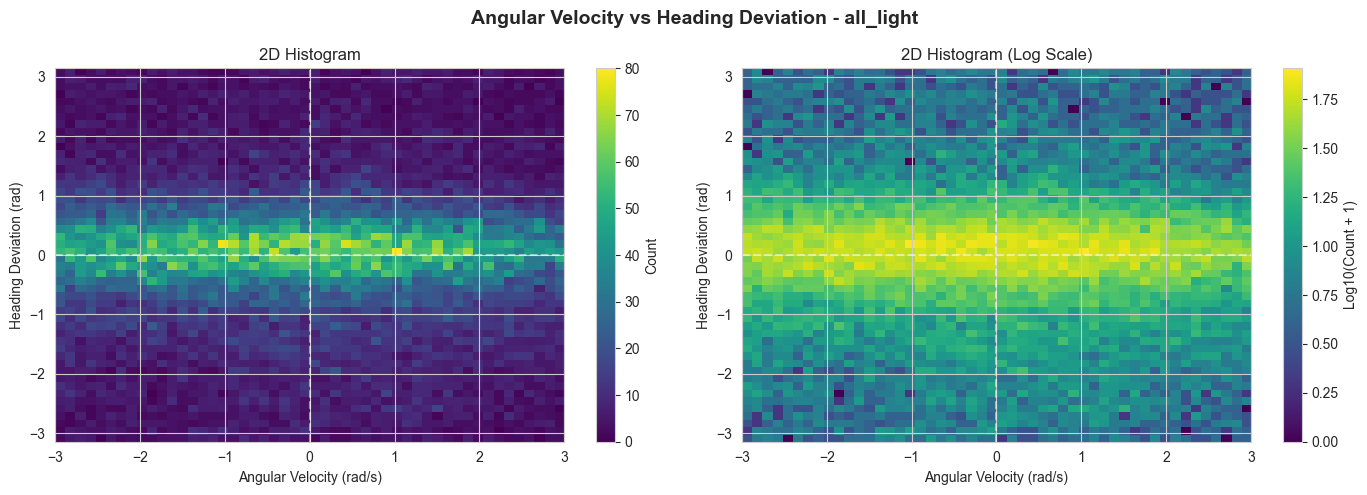

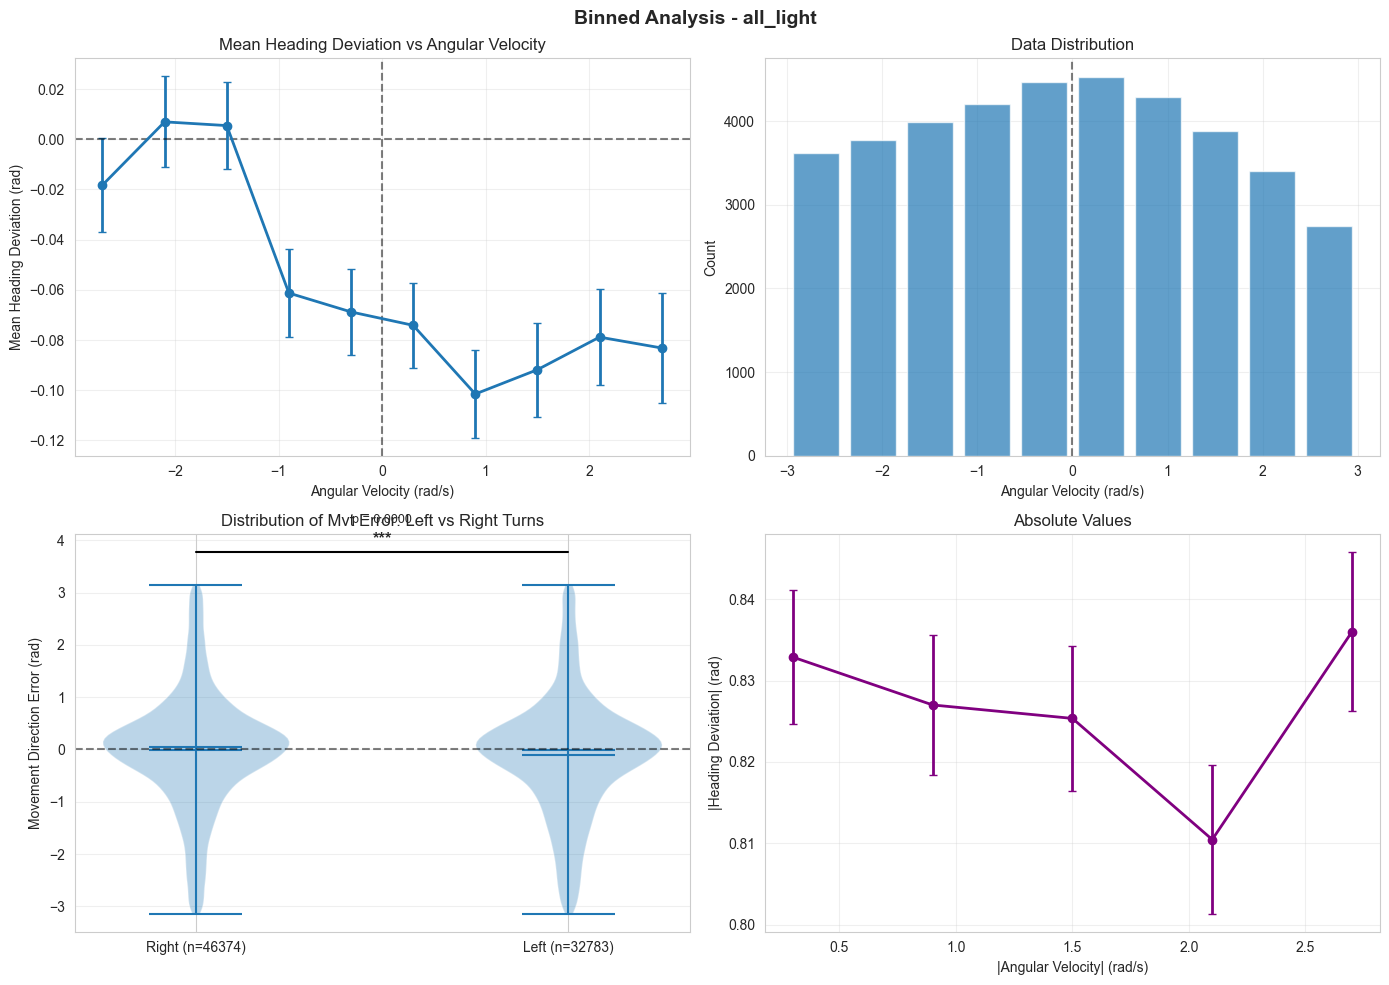

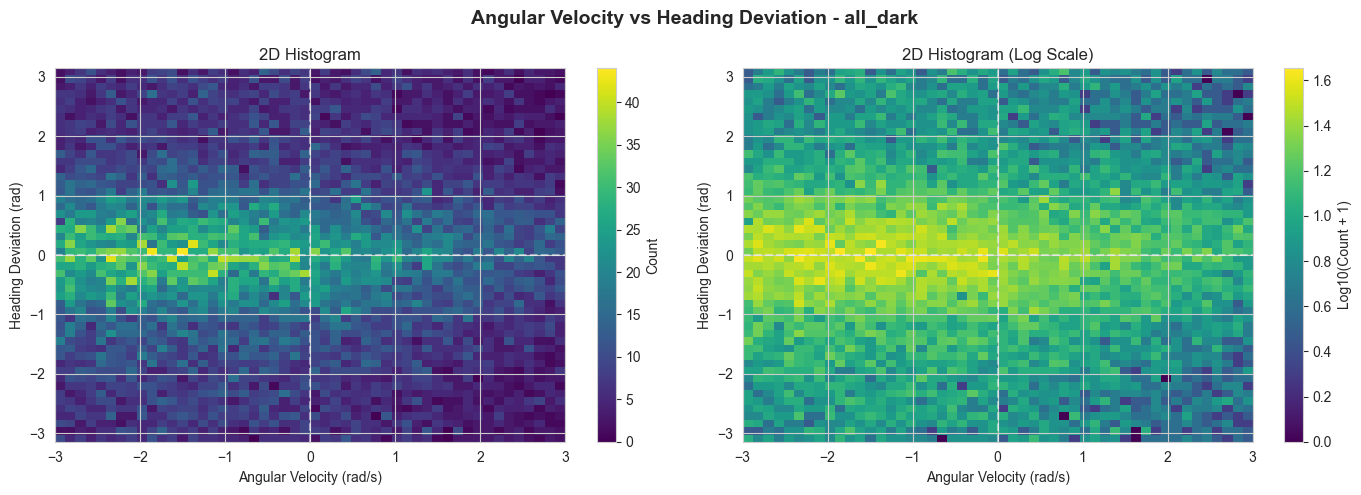

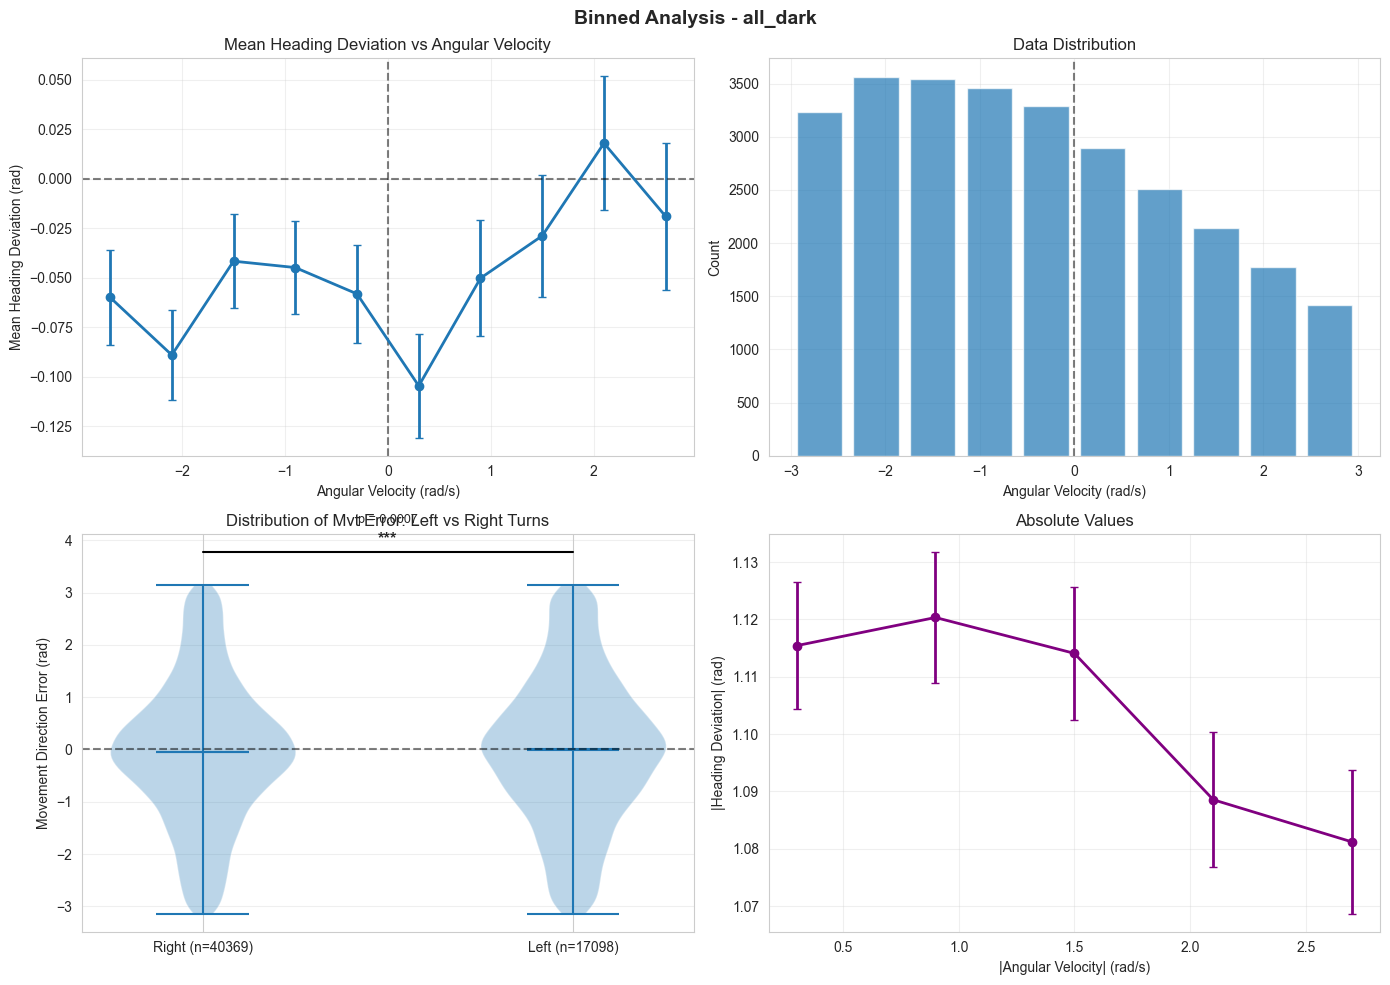

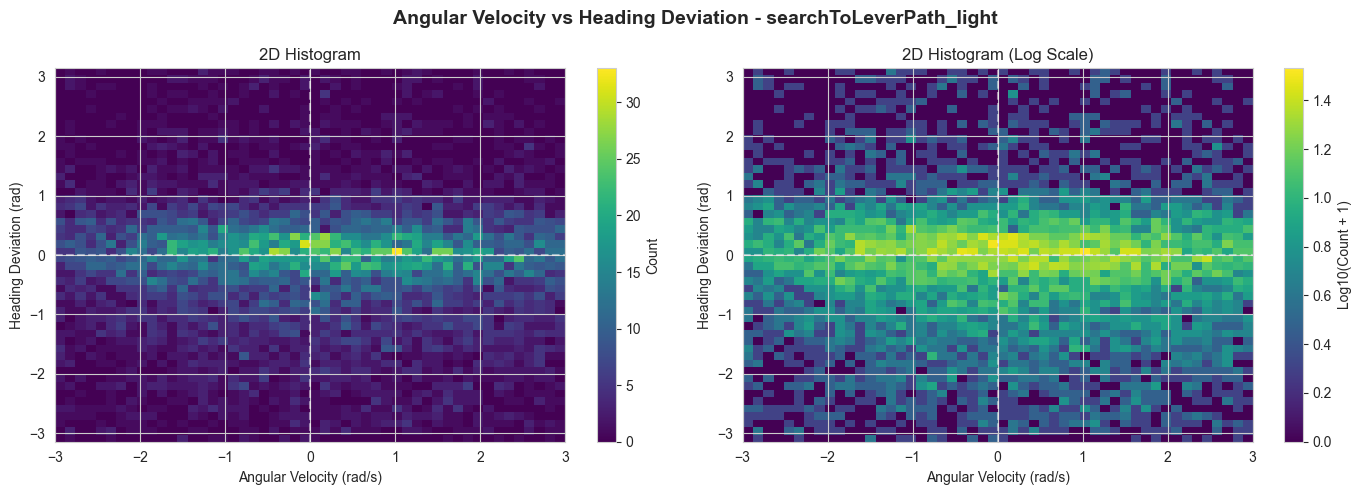

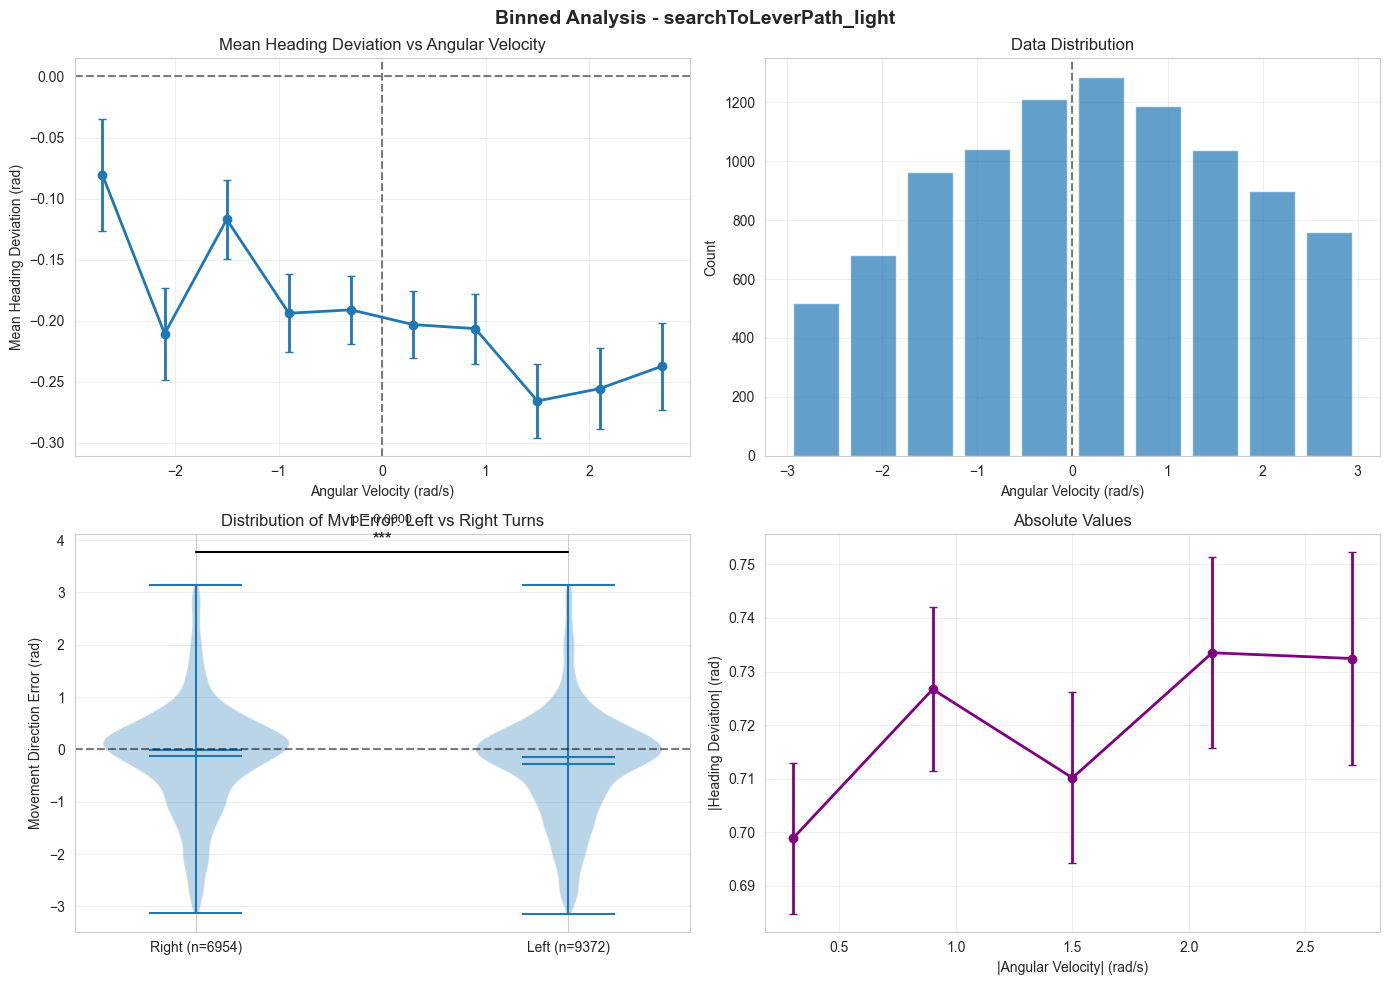

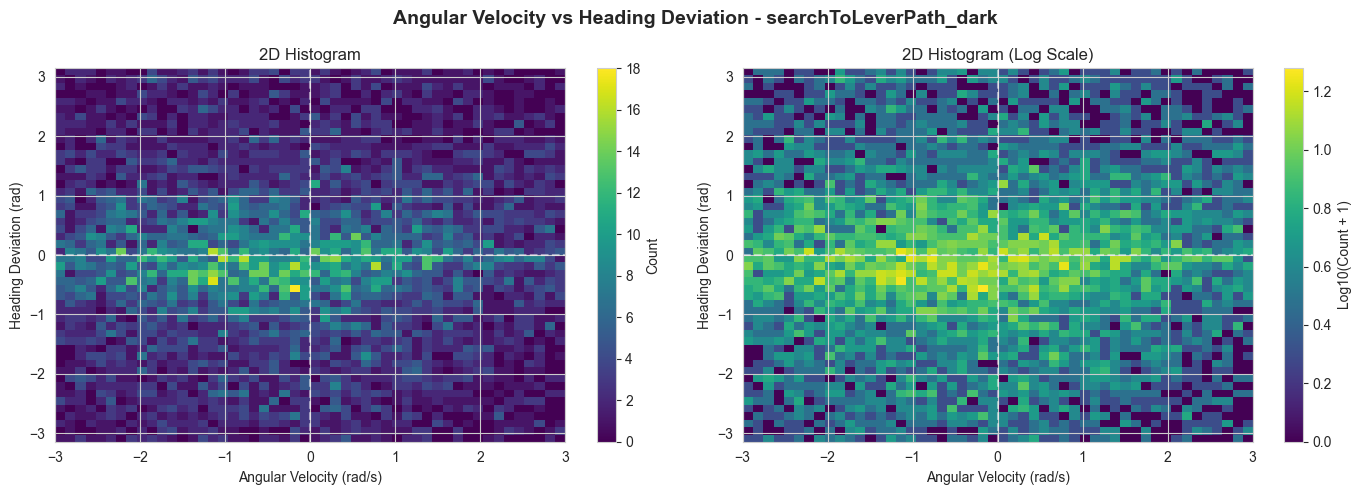

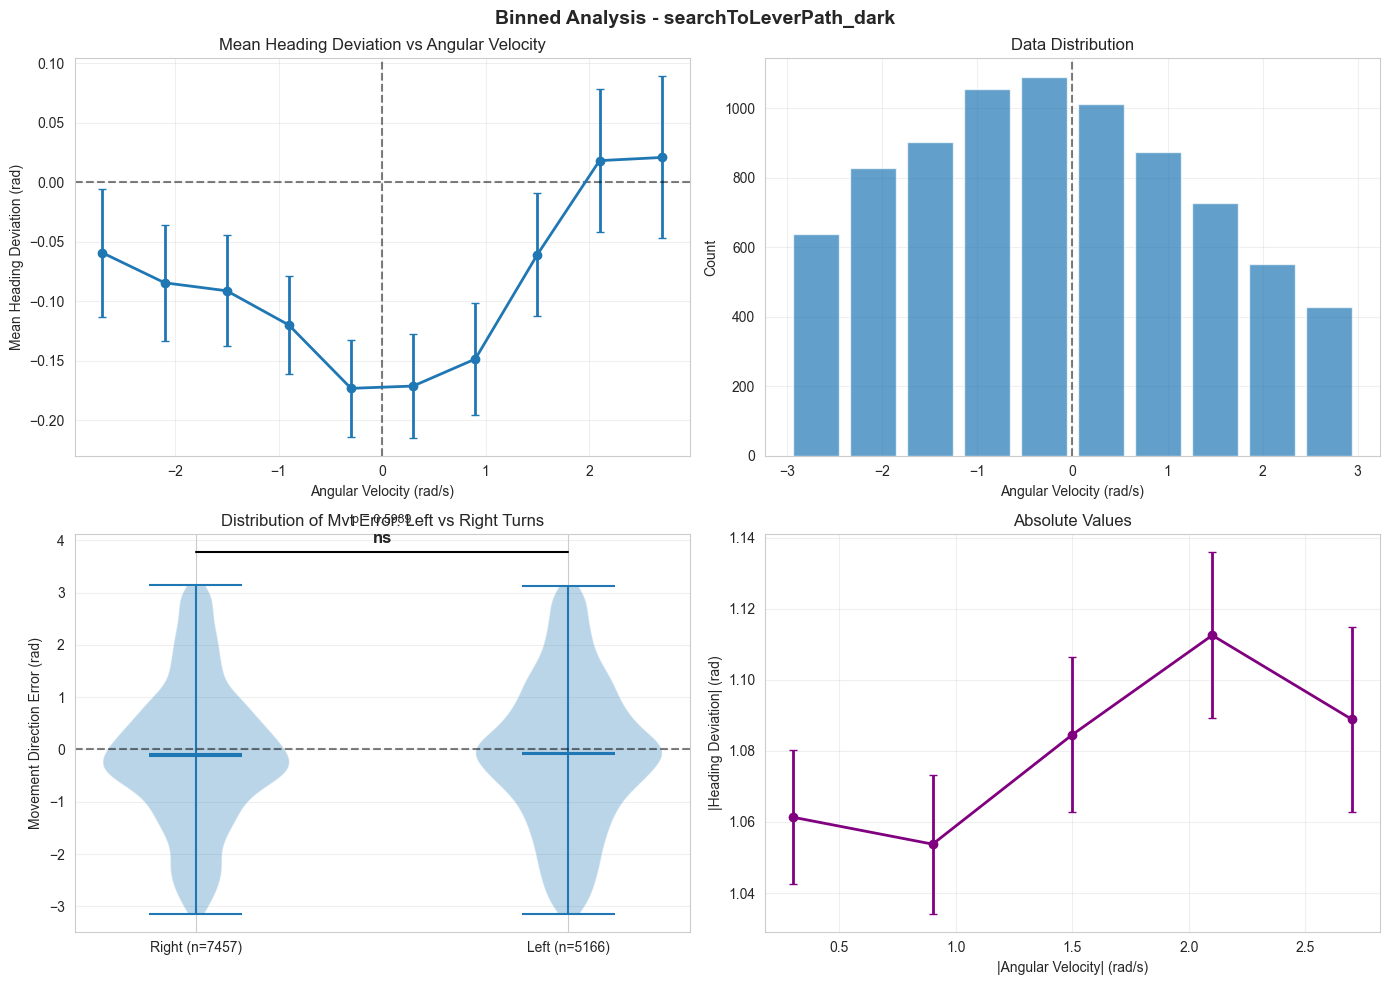

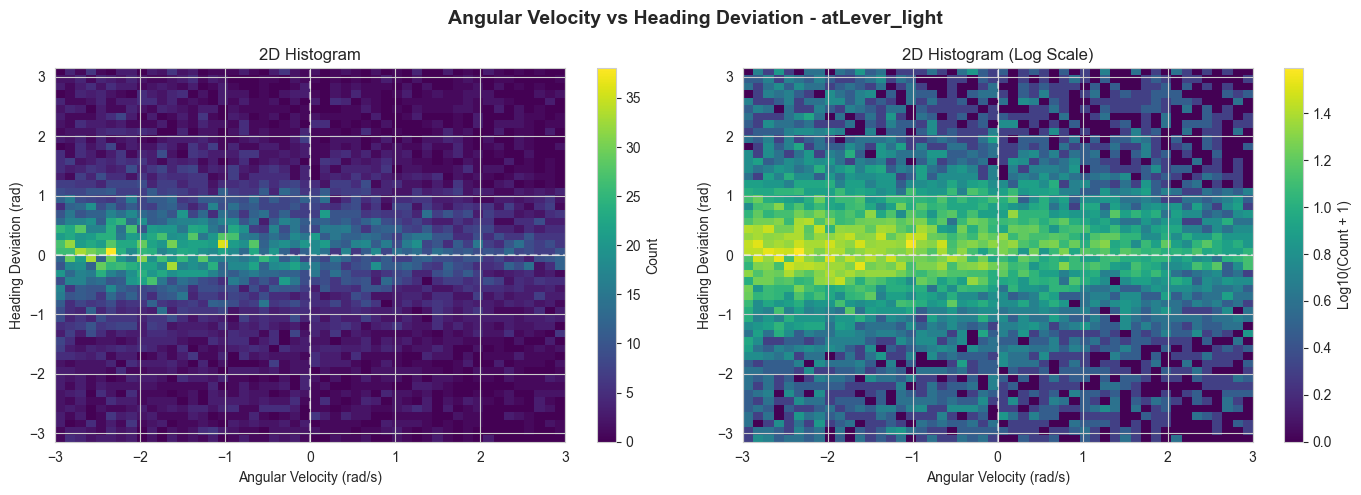

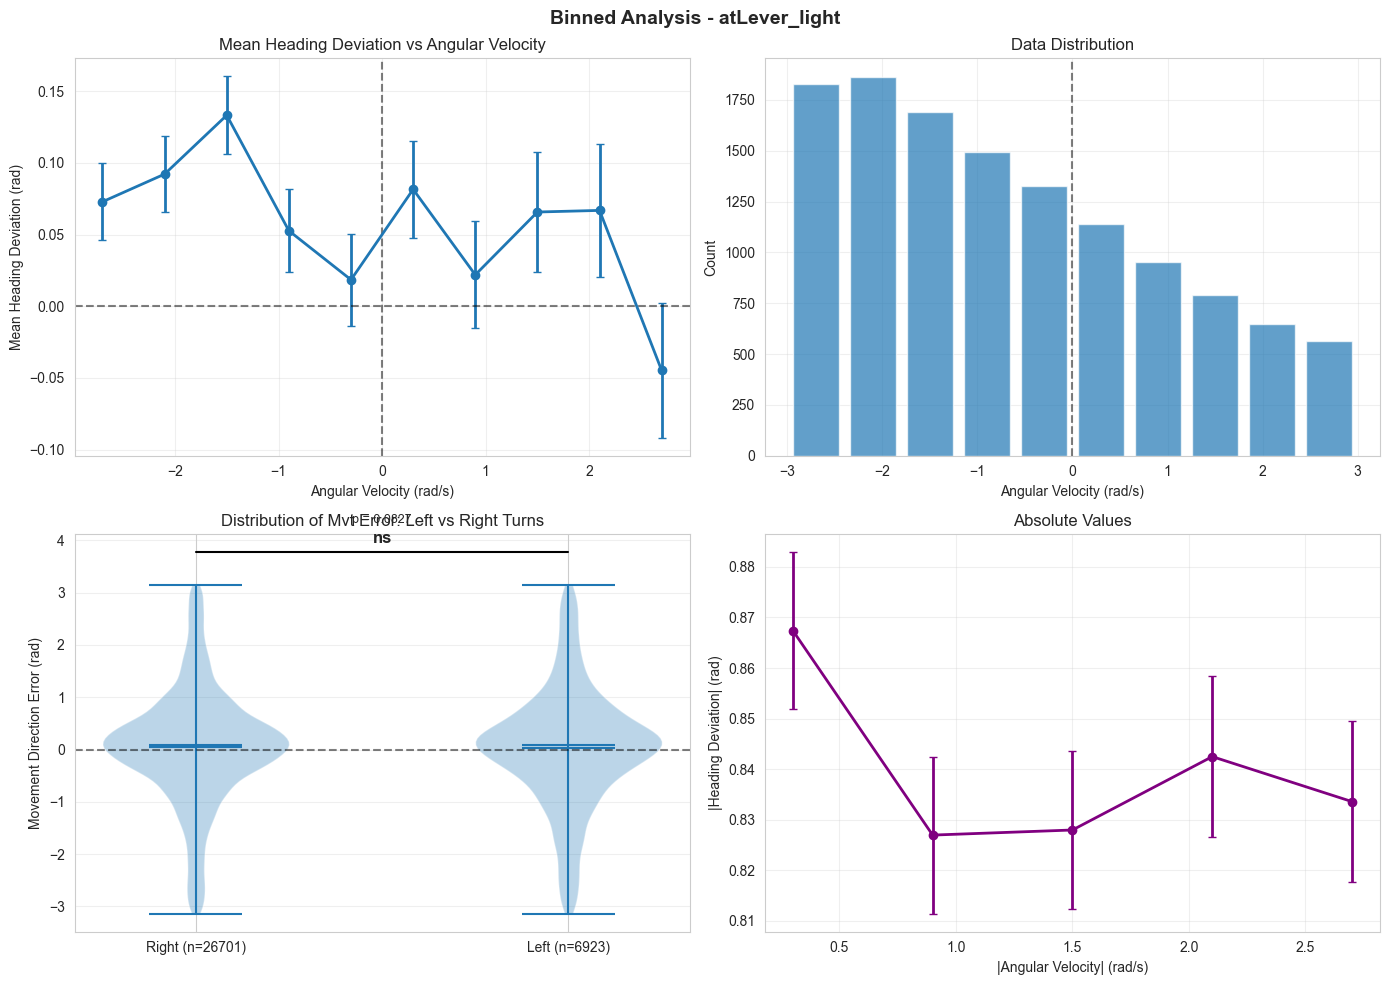

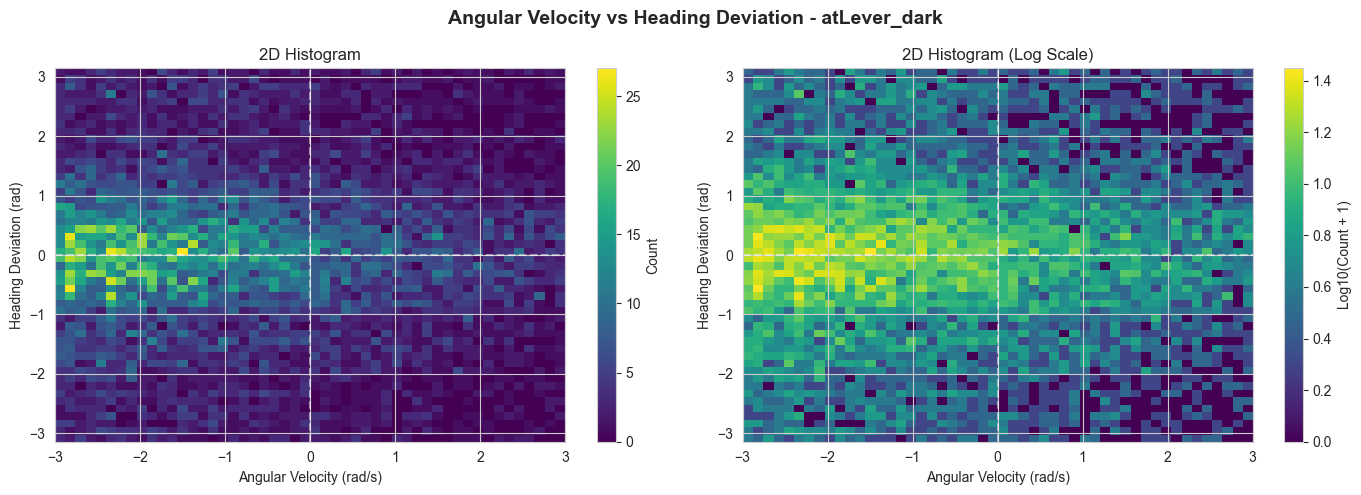

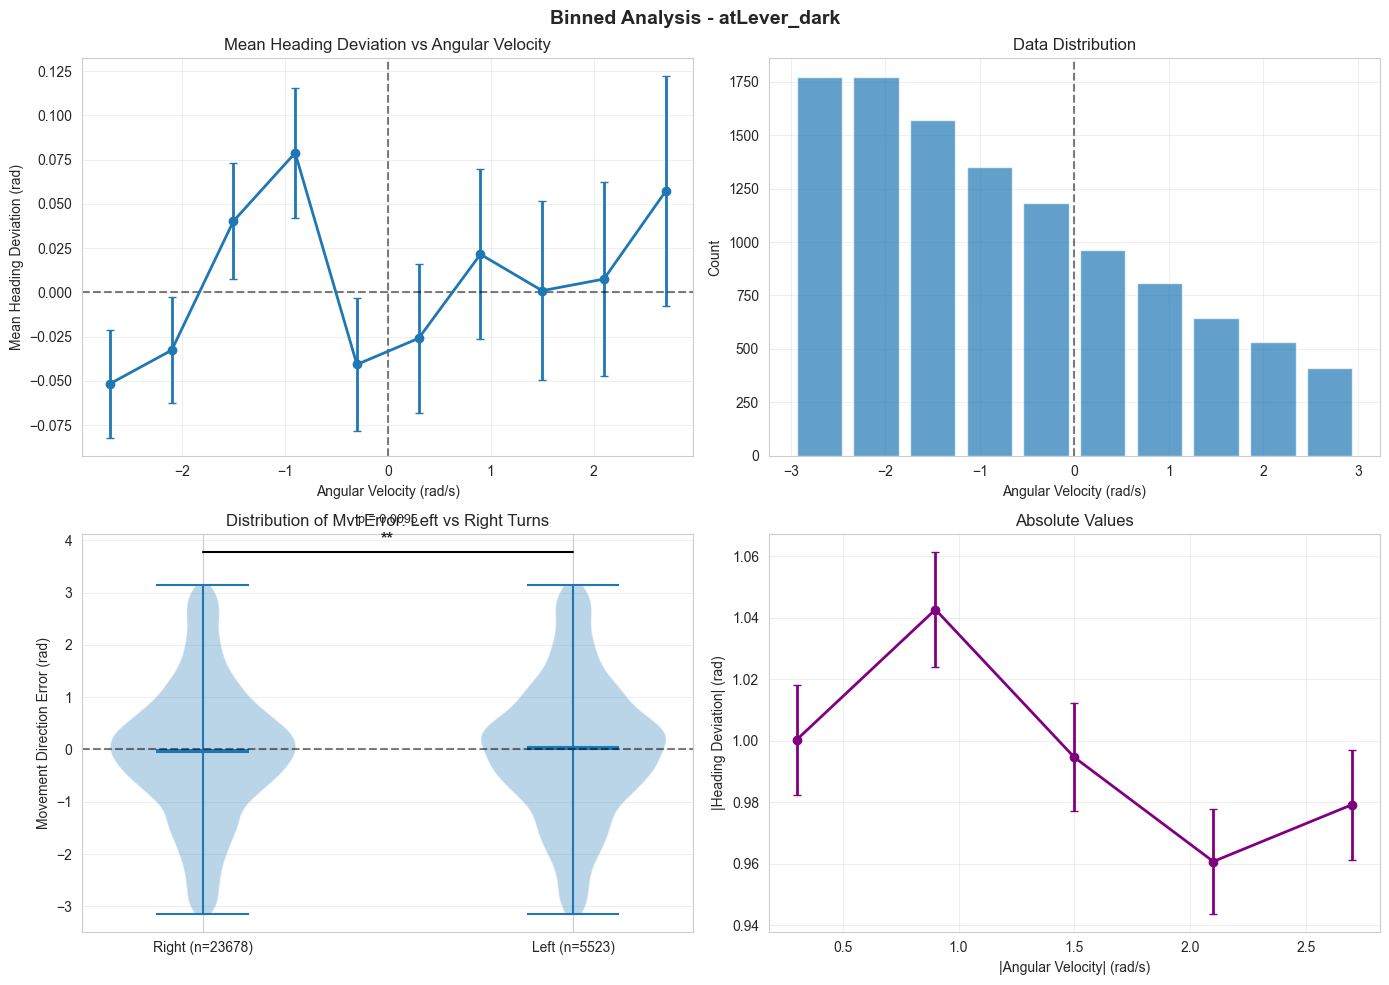

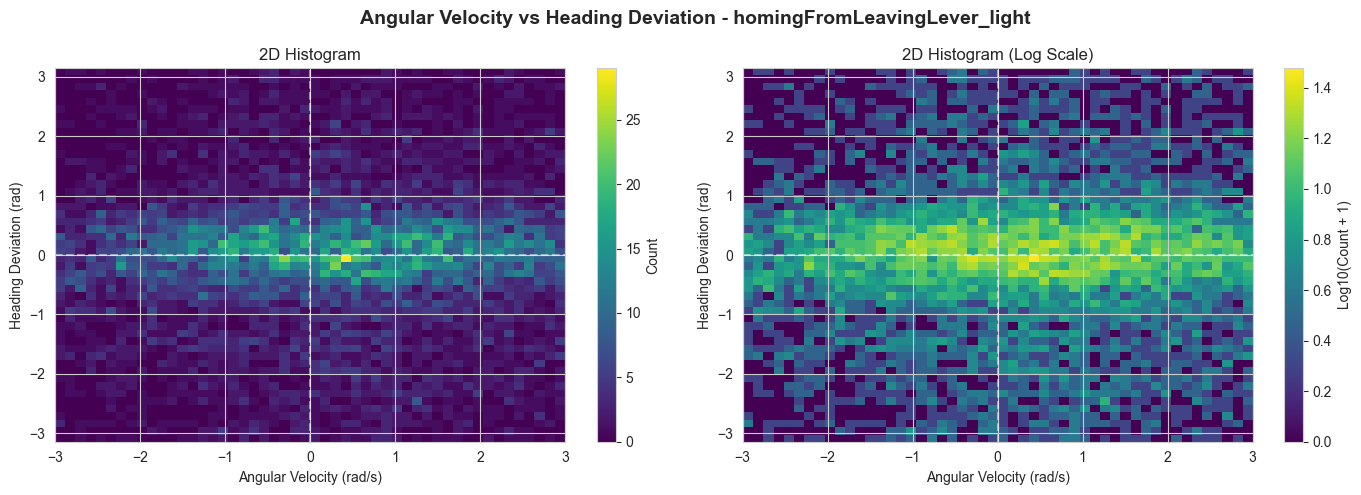

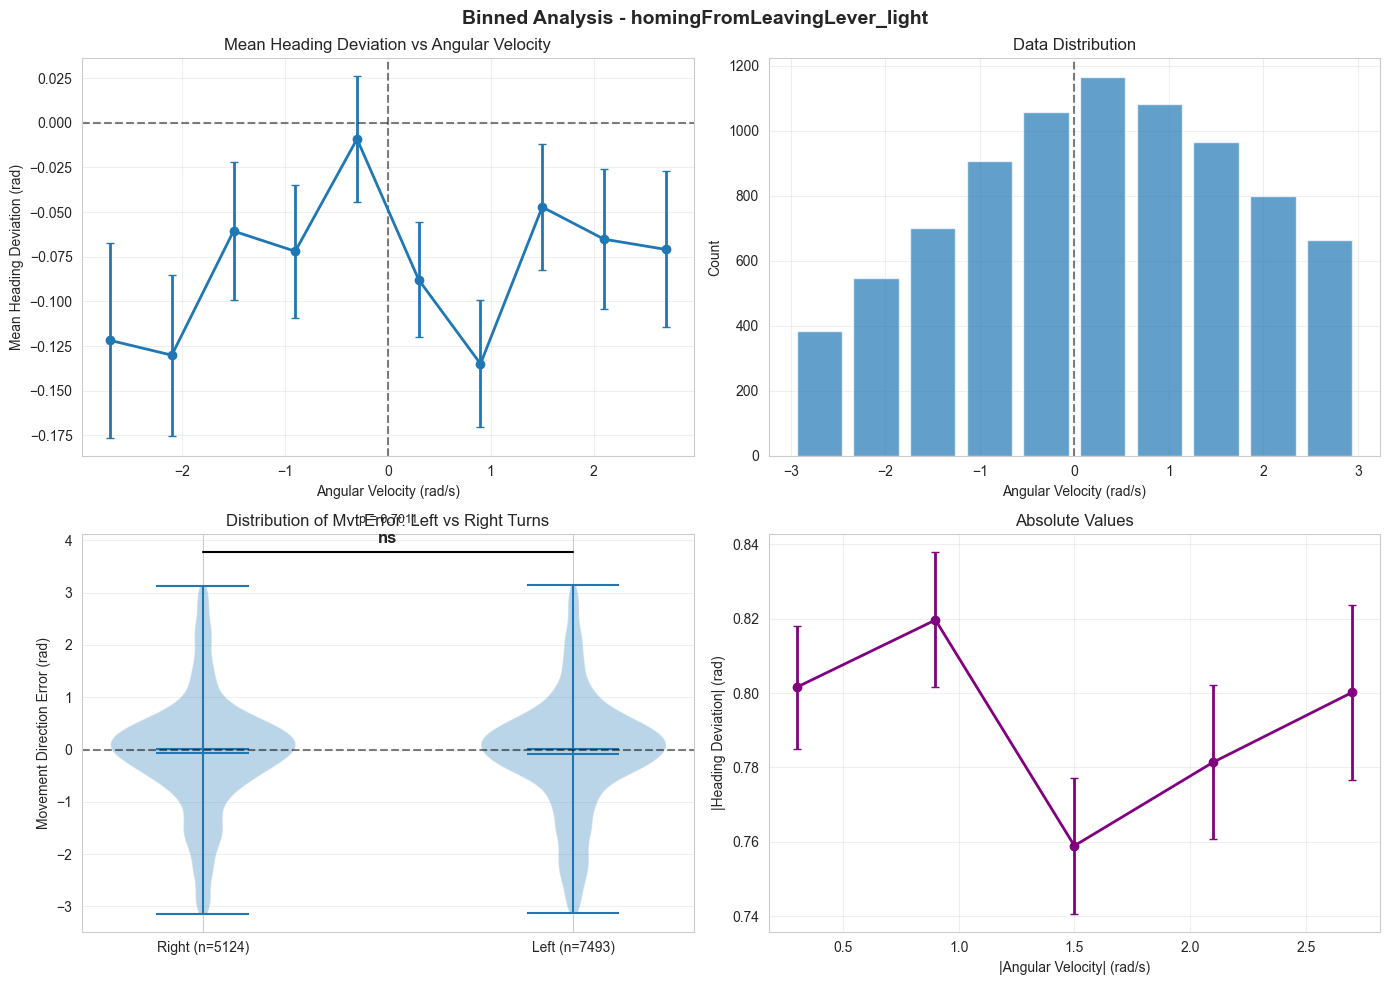

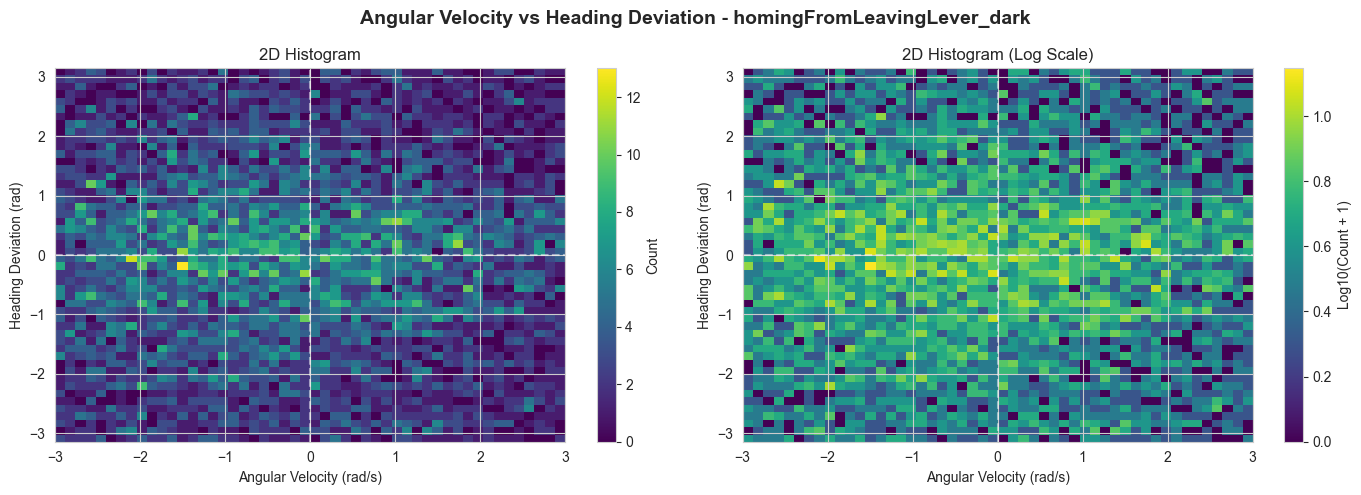

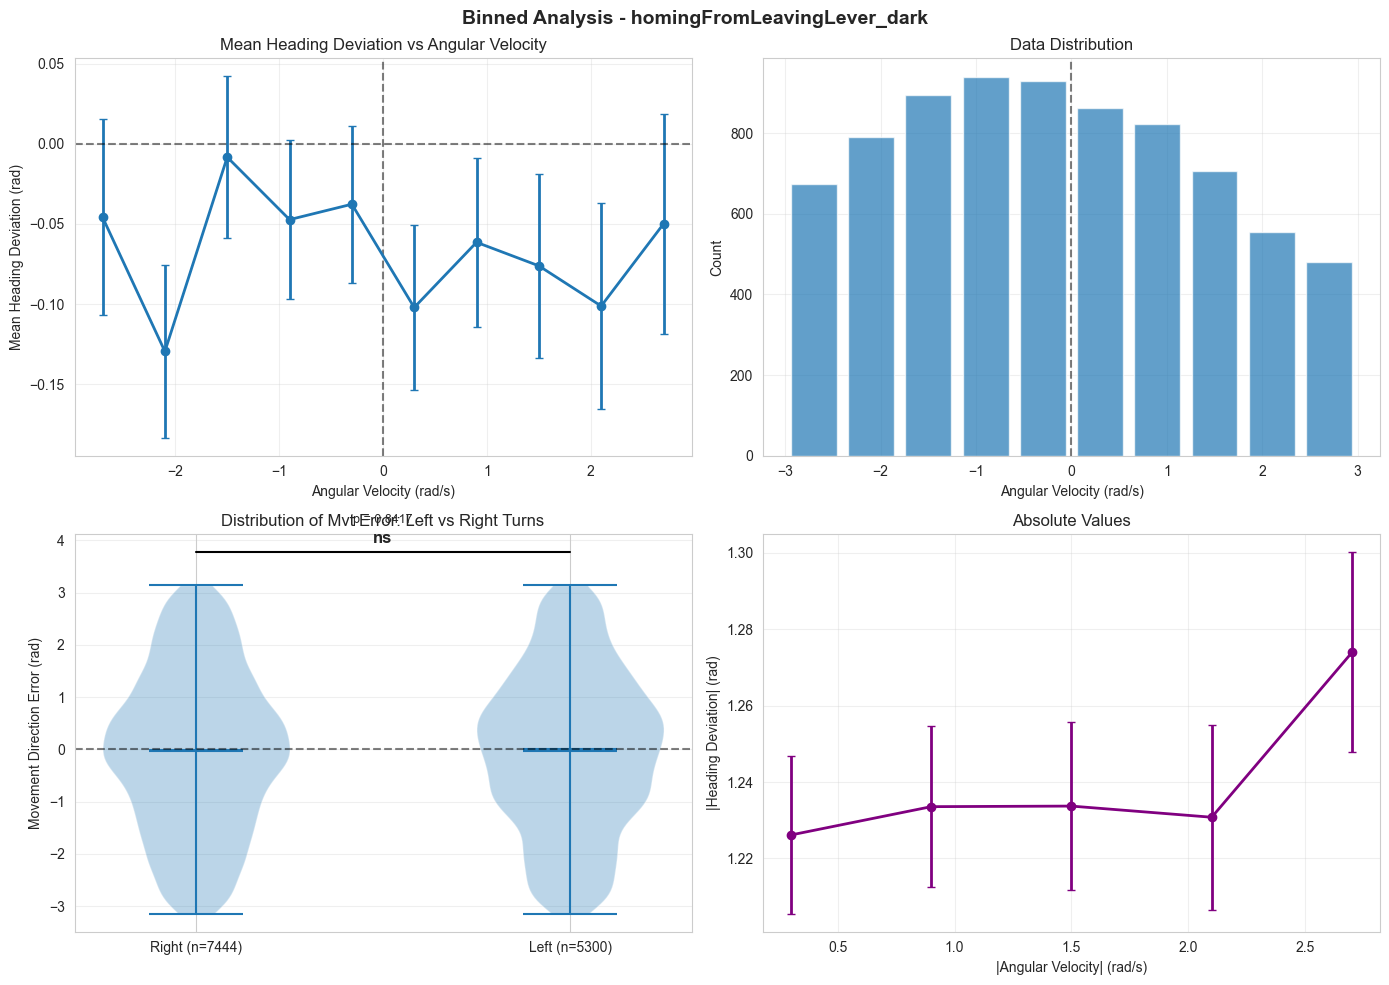

In [22]:
conditions_to_process = [
    'all_light',
    'all_dark',
    'searchToLeverPath_light',
    'searchToLeverPath_dark',
    'atLever_light',
    'atLever_dark',
    'homingFromLeavingLever_light',
    'homingFromLeavingLever_dark'
]

for condition in conditions_to_process:
    if len(all_data[condition]) > 0:
        produce_two_figures(all_data[condition], condition)

## Statistical Analysis

In [23]:
# Correlation analysis
for condition in conditions_to_process:
    if len(all_data[condition]) > 0:
        data = all_data[condition]
        corr, pval = stats.pearsonr(data['angular_velocity'], data['mvtDirError'])
        print(f"\n{condition}:")
        print(f"  Correlation: {corr:.4f}")
        print(f"  P-value: {pval:.6f}")
        
        left = data[data['angular_velocity'] > 0]
        right = data[data['angular_velocity'] < 0]
        if len(left) > 0 and len(right) > 0:
            t_stat, p_val = stats.ttest_ind(left['mvtDirError'], right['mvtDirError'])
            print(f"  Left vs Right t-test: t={t_stat:.3f}, p={p_val:.6f}")


all_light:
  Correlation: -0.0403
  P-value: 0.000000
  Left vs Right t-test: t=-12.331, p=0.000000

all_dark:
  Correlation: 0.0164
  P-value: 0.000086
  Left vs Right t-test: t=3.303, p=0.000958

searchToLeverPath_light:
  Correlation: -0.0801
  P-value: 0.000000
  Left vs Right t-test: t=-8.394, p=0.000000

searchToLeverPath_dark:
  Correlation: -0.0208
  P-value: 0.019496
  Left vs Right t-test: t=0.007, p=0.994164

atLever_light:
  Correlation: 0.0035
  P-value: 0.521357
  Left vs Right t-test: t=-1.748, p=0.080535

atLever_dark:
  Correlation: 0.0273
  P-value: 0.000003
  Left vs Right t-test: t=2.614, p=0.008950

homingFromLeavingLever_light:
  Correlation: -0.0229
  P-value: 0.010120
  Left vs Right t-test: t=-0.718, p=0.472489

homingFromLeavingLever_dark:
  Correlation: 0.0009
  P-value: 0.921490
  Left vs Right t-test: t=0.042, p=0.966652


## Summary

This analysis treats turning as a continuous variable rather than discrete events, which is more appropriate for animals making continuous small turns. The angular velocity approach:

1. **Captures all turning behavior** - from straight movement to sharp turns
2. **No arbitrary thresholds** - uses all data points
3. **Reveals relationships** - shows how heading deviation varies with turning rate
4. **Separates directions** - distinguishes left vs right turning effects

The 2D histograms show the joint distribution of angular velocity and heading deviation, while the binned analysis reveals systematic trends.